In [1]:
# Imports
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


/var/folders/07/j6s3cmcx0wq244hdbvw2l6v40000gp/T/ipykernel_78766/902213300.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
table = "new_db_Feb2023.csv"
opened = open(table,"r")
readed = pd.read_csv(table, sep=",", na_filter=True)
readed = readed.fillna(-3333)
print(readed)

         Unnamed: 0        source_name cadence       tmin       tmax  \
0                 0  4FGL J0001.2-0747   daily  239587201  239846401   
1                 1  4FGL J0001.5+2113   daily  239587201  239846401   
2                 2  4FGL J0003.3-1928   daily  239587201  239846401   
3                 3  4FGL J0004.3+4614   daily  239587201  239846401   
4                 4  4FGL J0004.4-4737   daily  239587201  239846401   
...             ...                ...     ...        ...        ...   
4132745     4132745  4FGL J2358.0-4601  weekly  698630401  699235201   
4132746     4132746  4FGL J2358.3-1021  weekly  698630401  699235201   
4132747     4132747  4FGL J2358.3+3830  weekly  698630401  699235201   
4132748     4132748  4FGL J2359.0+3922  weekly  698630401  699235201   
4132749     4132749  4FGL J2359.2-3134  weekly  698630401  699235201   

         photon_flux2  photon_flux_error2  photon_index2  return_code2  \
0        2.720000e-08        3.300000e-08           2.18     

In [3]:
#cadence = 'weekly'
cadence = 'monthly'

In [4]:
cadence_df = readed.loc[(readed['cadence'] == cadence) #& \
                        # (readed['ts2'] <= 4.) & \
                        # (readed['photon_flux_error2'] <  readed['photon_flux2'])
                        ]

#Set cuts on the TS, set as -3333 all those below the threshold
#cadence_df.loc[cadence_df['ts2'] <= 9., 'photon_flux2'] = -3333
cadence_df.loc[cadence_df['ts2'] <= 4., ['photon_flux2', 'photon_flux_error2']] = -3333
#Set as -3333 all points with an error larger than the flux
cadence_df.loc[cadence_df['photon_flux_error2'] > cadence_df['photon_flux2'], ['photon_flux2', 'photon_flux_error2']] = -3333
#Set cuts to remove possible outliers due to bad convergence of a bin
cadence_df.loc[cadence_df['photon_flux2'] > 1e-4, ['photon_flux2', 'photon_flux_error2']] = -3333
cadence_df.loc[cadence_df['photon_flux2'] < 1e-10, ['photon_flux2', 'photon_flux_error2']] = -3333
print(cadence_df)

TSTART = np.amin(cadence_df['tmin'])
TSTOP = np.amax(cadence_df['tmax'])

         Unnamed: 0        source_name  cadence       tmin       tmax  \
19826         19826  4FGL J0001.2-0747  monthly  239587201  242179201   
19828         19828  4FGL J0001.5+2113  monthly  239587201  242179201   
19830         19830  4FGL J0003.3-1928  monthly  239587201  242179201   
19832         19832  4FGL J0004.3+4614  monthly  239587201  242179201   
19834         19834  4FGL J0004.4-4737  monthly  239587201  242179201   
...             ...                ...      ...        ...        ...   
4125116     4125116  4FGL J2358.0-4601  monthly  695779201  698371201   
4125118     4125118  4FGL J2358.3-1021  monthly  695779201  698371201   
4125120     4125120  4FGL J2358.3+3830  monthly  695779201  698371201   
4125122     4125122  4FGL J2359.0+3922  monthly  695779201  698371201   
4125124     4125124  4FGL J2359.2-3134  monthly  695779201  698371201   

         photon_flux2  photon_flux_error2  photon_index2  return_code2   ts2  
19826         -3333.0             -3333.0   

In [5]:
names = np.unique(readed['source_name']) #.drop_duplicates(subset=['source_name'], inplace=False)#[1]
print(names, len(names))

['4FGL J0001.2-0747' '4FGL J0001.5+2113' '4FGL J0003.3-1928' ...
 '4FGL J2358.3-1021' '4FGL J2359.0+3922' '4FGL J2359.2-3134'] 1525


In [6]:
from variability_amplitude import amp
from fermi_catalog import select_bll, select_fsrq, select_bcu

In [7]:
fsrq_df = select_fsrq()
fsrq_names = fsrq_df['Source_Name']

#I added a list to append individually fvar and the error, as well as the average flux
#It is redundant since everything is also stored in fsrq_fractionalflux, but it does not 
#consume a lot of time and for fast checks it might be accessed more easily 
fsrq_avflux = []
fsrq_amp = []
fsrq_amp_err = []
fsrq_fmatrix = []
fsrq_fractionalflux = []
fsrq_nanbins = []
fsrq_nanbinsmatrix = []
fsrq_minflux=[]
fsrq_maxflux=[]
for i, fsrq in enumerate(fsrq_names):
    #This is just to delete variables to avoid problems due to overwriting
    delete_variables=['averageflux','source_array','flux','flux_err','amp_percent','amp_percent_err','factors','count']
    for j,variable in enumerate(delete_variables):
        if variable in globals():
            del variable
    delete_variables=['averageflux','source_array','flux','flux_err','amp_percent','amp_percent_err','factors','count']
    for j,variable in enumerate(delete_variables):
        if variable in locals():
            del variable
    # print(i, bcu)
    source_array = cadence_df.loc[cadence_df['source_name'] == fsrq]
    count = np.count_nonzero(source_array['photon_flux2'] != -3333)
    if count>1: #Since we are interested in variability, we exclude sources with just 1 no-nan value
        averageflux = np.mean(source_array[source_array['photon_flux2']!=-3333]['photon_flux2'])
        
        flux = np.array(source_array[source_array['photon_flux2']!=-3333]['photon_flux2'])
        flux_err = np.array(source_array[source_array['photon_flux_error2']!=-3333]['photon_flux_error2'])
        amp_percent, amp_percent_err = amp(flux, flux_err)
    
        factors = source_array['photon_flux2']/averageflux
        #factors = source_array['photon_flux2']/np.min(source_array[source_array['photon_flux2']!=-3333]['photon_flux2'])
        fsrq_nanbins.append(len(source_array[source_array['photon_flux2']== -3333]['photon_flux2']))
        fsrq_nanbinsmatrix.append(np.array(source_array['photon_flux2'] == -3333))
        fsrq_fmatrix.append(factors.tolist())
        fsrq_fractionalflux.append([fsrq, averageflux, amp_percent, amp_percent_err])
        fsrq_avflux.append(averageflux)
        fsrq_amp.append(amp_percent)
        fsrq_amp_err.append(amp_percent_err)
        fsrq_minflux.append(np.min(source_array[source_array['photon_flux2']!=-3333]['photon_flux2']))
        fsrq_maxflux.append(np.max(source_array[source_array['photon_flux2']!=-3333]['photon_flux2']))

fsrq_fmatrix = np.array(fsrq_fmatrix)
fsrq_nanbinsmatrix = np.array(fsrq_nanbinsmatrix)

print(fsrq_amp)
print(fsrq_amp_err)

-----------------------------
Selecting FSRQ type blazars
Total number of variable objects: 572
[555.3700929196225, 208.03073044835244, 206.30981887511916, 348.97756889140334, 275.0773678096707, 266.01580028010824, 373.51092814980035, 256.14307931570767, 361.72916021072206, 333.7214070234015, 187.2728194790458, 208.00193050193045, 180.14712667923484, 745.7816101219989, 645.5749583215909, 480.8138490996664, 327.61218528450394, 183.6479902557856, 259.6175360255928, 293.43784788194824, 440.84311498169893, 253.82610498464823, 292.81191662978, 251.26941180830957, 232.71884453986533, 186.57554308030262, 244.87936268307382, 485.91551920102864, 261.5412979351032, 683.1287611342135, 569.0473741944332, 184.10778655425767, 1588.4707526911386, 315.39075690745125, 453.44654484954526, 774.5219377235602, 836.5433398745988, 252.7490797607212, 417.99112699273087, 234.81746672045176, 154.3621738682066, 364.316007857969, 909.6946465158222, 154.1396912977376, 382.0162094387211, 445.1619174297846, 262.6526

In [8]:
bll_df = select_bll()
bll_names = bll_df['Source_Name']

#I added a list to append individually fvar and the error, as well as the average flux
#It is redundant since everything is also stored in bll_fractionalflux, but it does not 
#consume a lot of time and for fast checks it might be accessed more easily 
bll_avflux = []
bll_amp = []
bll_amp_err = []
bll_fmatrix = []
bll_fractionalflux = []
bll_nanbins = []
bll_nanbinsmatrix = []
bll_minflux=[]
bll_maxflux=[]
for i, bll in enumerate(bll_names):
    #This is just to delete variables to avoid problems due to overwriting
    delete_variables=['averageflux','source_array','flux','flux_err','amp_percent','amp_percent_err','factors','count']
    for j,variable in enumerate(delete_variables):
        if variable in globals():
            del variable
    delete_variables=['averageflux','source_array','flux','flux_err','amp_percent','amp_percent_err','factors','count']
    for j,variable in enumerate(delete_variables):
        if variable in locals():
            del variable
    # print(i, bcu)
    source_array = cadence_df.loc[cadence_df['source_name'] == bll]
    count = np.count_nonzero(source_array['photon_flux2'] != -3333)
    if count>1: #Since we are interested in variability, we exclude sources with just 1 no-nan value
        averageflux = np.mean(source_array[source_array['photon_flux2']!=-3333]['photon_flux2'])
        
        flux = np.array(source_array[source_array['photon_flux2']!=-3333]['photon_flux2'])
        flux_err = np.array(source_array[source_array['photon_flux_error2']!=-3333]['photon_flux_error2'])
        amp_percent, amp_percent_err = amp(flux, flux_err)
        
        factors = source_array['photon_flux2']/averageflux
        #factors = source_array['photon_flux2']/np.min(source_array[source_array['photon_flux2']!=-3333]['photon_flux2'])
        bll_nanbins.append(len(source_array[source_array['photon_flux2']==-3333]['photon_flux2']))
        bll_nanbinsmatrix.append(np.array(source_array['photon_flux2'] == -3333))
        bll_fmatrix.append(factors.tolist())
        bll_fractionalflux.append([bll, averageflux, amp_percent, amp_percent_err])
        bll_avflux.append(averageflux)
        bll_amp.append(amp_percent)
        bll_amp_err.append(amp_percent_err)
        bll_minflux.append(np.min(source_array[source_array['photon_flux2']!=-3333]['photon_flux2']))
        bll_maxflux.append(np.max(source_array[source_array['photon_flux2']!=-3333]['photon_flux2']))

bll_fmatrix = np.array(bll_fmatrix)
bll_nanbinsmatrix = np.array(bll_nanbinsmatrix)


-----------------------------
Selecting BL Lac type blazars
Total number of variable objects: 477


In [9]:
bcu_df = select_bcu()
bcu_names = bcu_df['Source_Name']

#I added a list to append individually fvar and the error, as well as the average flux
#It is redundant since everything is also stored in bcu_fractionalflux, but it does not 
#consume a lot of time and for fast checks it might be accessed more easily 
bcu_avflux = []
bcu_amp = []
bcu_amp_err = []
bcu_fmatrix = []
bcu_fractionalflux = []
bcu_nanbins = []
bcu_nanbinsmatrix = []
bcu_minflux=[]
bcu_maxflux=[]
for i, bcu in enumerate(bcu_names):
    #This is just to delete variables to avoid problems due to overwriting
    delete_variables=['averageflux','source_array','flux','flux_err','amp_percent','amp_percent_err','factors','count']
    for j,variable in enumerate(delete_variables):
        if variable in globals():
            del variable
    delete_variables=['averageflux','source_array','flux','flux_err','amp_percent','amp_percent_err','factors','count']
    for j,variable in enumerate(delete_variables):
        if variable in locals():
            del variable
    # print(i, bcu)
    source_array = cadence_df.loc[cadence_df['source_name'] == bcu]
    count = np.count_nonzero(source_array['photon_flux2'] != -3333)
    if count>1: #Since we are interested in variability, we exclude sources with just 1 no-nan value
        averageflux = np.mean(source_array[source_array['photon_flux2']!=-3333]['photon_flux2'])
        
        flux = np.array(source_array[source_array['photon_flux2']!=-3333]['photon_flux2'])
        flux_err = np.array(source_array[source_array['photon_flux_error2']!=-3333]['photon_flux_error2'])
        amp_percent, amp_percent_err = amp(flux, flux_err)
    
        factors = source_array['photon_flux2']/averageflux
        #factors = source_array['photon_flux2']/np.min(source_array[source_array['photon_flux2']!=-3333]['photon_flux2'])
        bcu_nanbins.append(len(source_array[source_array['photon_flux2']==-3333]['photon_flux2']))
        bcu_nanbinsmatrix.append(np.array(source_array['photon_flux2'] == -3333))
        bcu_fmatrix.append(factors.tolist())
        bcu_fractionalflux.append([bcu, averageflux, amp_percent, amp_percent_err])
        bcu_avflux.append(averageflux)
        bcu_amp.append(amp_percent)
        bcu_amp_err.append(amp_percent_err)
        bcu_minflux.append(np.min(source_array[source_array['photon_flux2']!=-3333]['photon_flux2']))
        bcu_maxflux.append(np.max(source_array[source_array['photon_flux2']!=-3333]['photon_flux2']))

bcu_fmatrix = np.array(bcu_fmatrix)
bcu_nanbinsmatrix = np.array(bcu_nanbinsmatrix)


-----------------------------
Selecting unknown type blazars
Total number of variable objects: 364


18.679114500247156
18.46331934597019
21.402988314460398


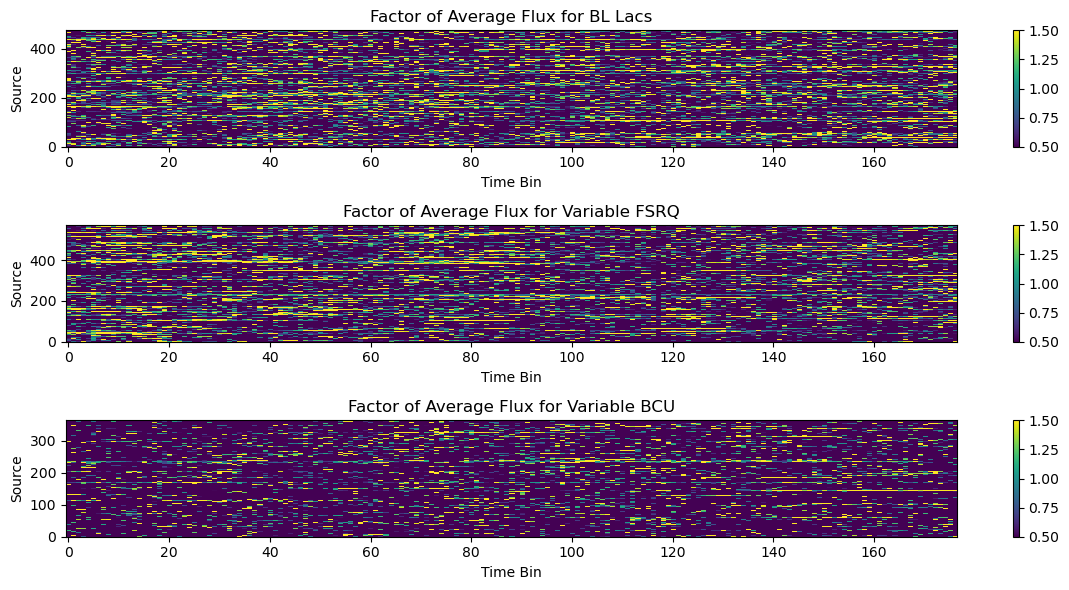

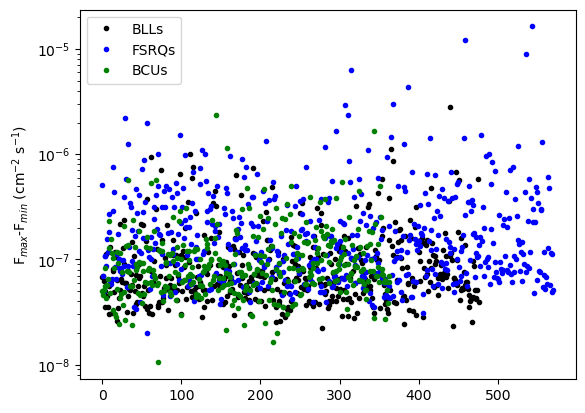

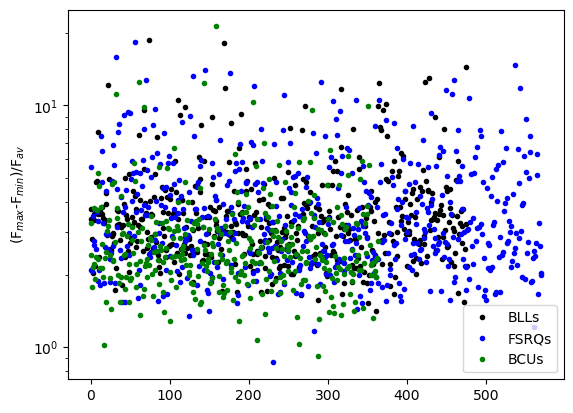

In [10]:
import matplotlib
cmap = matplotlib.cm.bone
import matplotlib.colors as colors

cmap.set_bad('Red',1.)

fig, ax = plt.subplots(3, 1, figsize=(12,6), sharex=True, )
bll_fmatrix_masked =  np.ma.masked_where(bll_nanbinsmatrix <0, bll_fmatrix)
fsrq_fmatrix_masked =  np.ma.masked_where(fsrq_nanbinsmatrix <0, fsrq_fmatrix)
bcu_fmatrix_masked =  np.ma.masked_where(bcu_nanbinsmatrix <0, bcu_fmatrix)
cax1 = ax[0].imshow(bll_fmatrix_masked, aspect='auto', interpolation='nearest', origin='lower', cmap='viridis')#, extent=[TSTART/1e8, TSTOP/1e8, 0, len(bll_fmatrix)])
cax2 = ax[1].imshow(fsrq_fmatrix_masked, aspect='auto', interpolation='nearest', origin='lower', cmap='viridis')#, extent=[TSTART/1e8, TSTOP/1e8, 0, len(bll_fmatrix)])
cax3 = ax[2].imshow(bcu_fmatrix_masked, aspect='auto', interpolation='nearest', origin='lower', cmap='viridis')#, extent=[TSTART/1e8, TSTOP/1e8, 0, len(bll_fmatrix)])

print(np.max(bll_fmatrix_masked))
print(np.max(fsrq_fmatrix_masked))
print(np.max(bcu_fmatrix_masked))

cax1.set_clim(0.5,1.5)
cax2.set_clim(0.5,1.5)
cax3.set_clim(0.5,1.5)

plt.colorbar(cax1, ax=ax[0])
plt.colorbar(cax2, ax=ax[1])
plt.colorbar(cax3, ax=ax[2])

ax[0].set_title("Factor of Average Flux for BL Lacs")
ax[0].set_xlabel("Time Bin")
ax[0].set_ylabel("Source")
ax[1].set_title("Factor of Average Flux for Variable FSRQ")
ax[1].set_xlabel("Time Bin")
ax[1].set_ylabel("Source")
ax[2].set_title("Factor of Average Flux for Variable BCU")
ax[2].set_xlabel("Time Bin")
ax[2].set_ylabel("Source")

ax[0].xaxis.set_ticks_position('bottom')
ax[1].xaxis.set_ticks_position('bottom')
ax[2].xaxis.set_ticks_position('bottom')

fig.tight_layout()

plt.figure()
plt.plot(np.array(bll_maxflux)-np.array(bll_minflux),'.k',label='BLLs')
plt.plot(np.array(fsrq_maxflux)-np.array(fsrq_minflux),'.b',label='FSRQs')
plt.plot(np.array(bcu_maxflux)-np.array(bcu_minflux),'.g',label='BCUs')
plt.ylabel(r'F$_{max}$-F$_{min}$ (cm$^{-2}$ s$^{-1}$)')
plt.yscale('log')
plt.legend(loc='best')

plt.figure()
plt.plot((np.array(bll_maxflux)-np.array(bll_minflux))/bll_avflux,'.k',label='BLLs')
plt.plot((np.array(fsrq_maxflux)-np.array(fsrq_minflux))/fsrq_avflux,'.b',label='FSRQs')
plt.plot((np.array(bcu_maxflux)-np.array(bcu_minflux))/bcu_avflux,'.g',label='BCUs')
plt.ylabel(r'(F$_{max}$-F$_{min}$)/F$_{av}$')
plt.yscale('log')
plt.legend(loc='best')


Median flux values for the different types of blazars
BLLs
2.1976818181818183e-08
FSRQs
4.1589361702127655e-08
BCUs
3.3333067978533095e-08


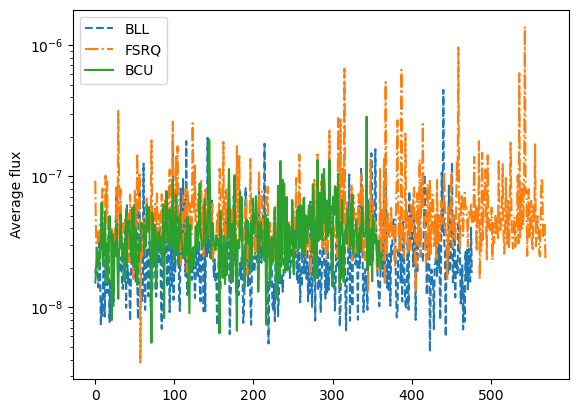

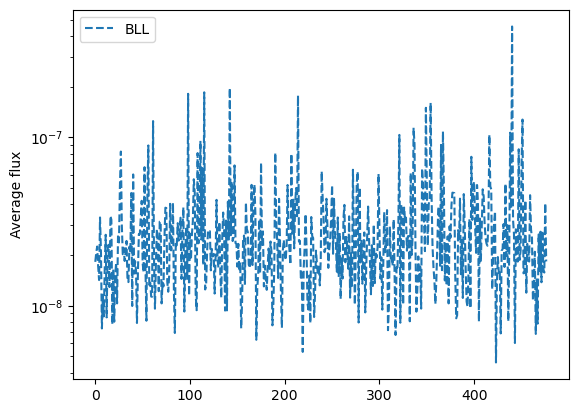

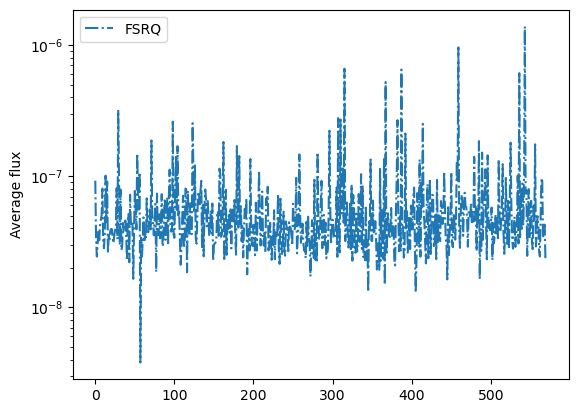

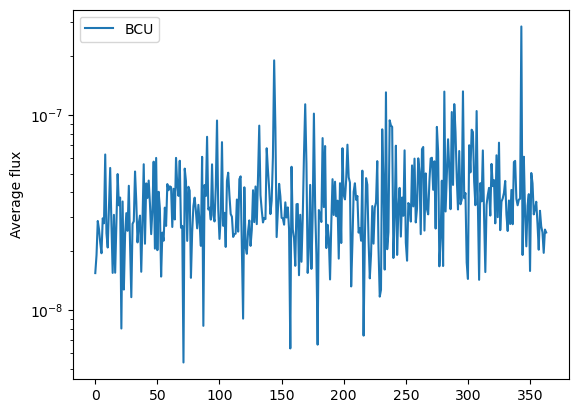

In [11]:
#Mean flux
plt.figure()
plt.plot(bll_avflux,linestyle='--',label='BLL')
plt.plot(fsrq_avflux,linestyle='-.',label='FSRQ')
plt.plot(bcu_avflux,linestyle='-',label='BCU')
plt.yscale('log')
plt.ylabel('Average flux')
plt.legend(loc='best')

plt.figure()
plt.plot(bll_avflux,linestyle='--',label='BLL')
plt.yscale('log')
plt.ylabel('Average flux')
plt.legend(loc='best')

plt.figure()
plt.plot(fsrq_avflux,linestyle='-.',label='FSRQ')
plt.yscale('log')
plt.ylabel('Average flux')
plt.legend(loc='best')

plt.figure()
plt.plot(bcu_avflux,linestyle='-',label='BCU')
plt.yscale('log')
plt.ylabel('Average flux')
plt.legend(loc='best')

import math

filtered_bll_avflux = [x for x in bll_avflux if not math.isnan(x)]
filtered_fsrq_avflux = [x for x in fsrq_avflux if not math.isnan(x)]
filtered_bcu_avflux = [x for x in bcu_avflux if not math.isnan(x)]

#Mean Fvar values
print('Median flux values for the different types of blazars')
print('BLLs')
print(np.median(filtered_bll_avflux))
print('FSRQs')
print(np.median(filtered_fsrq_avflux))
print('BCUs')
print(np.median(filtered_bcu_avflux))

Mean Amp values for the different types of blazars
BLLs
373.5512054527649
FSRQs
390.7877468218885
BCUs
290.4653854714707


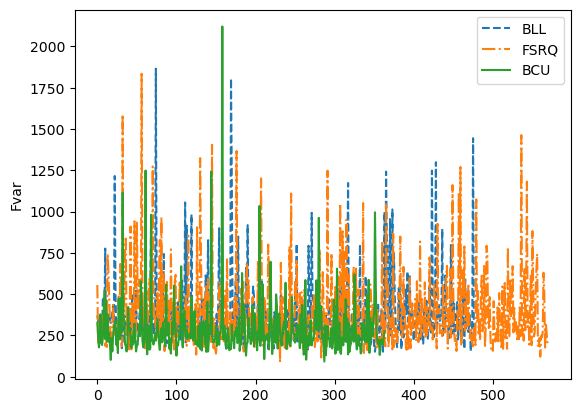

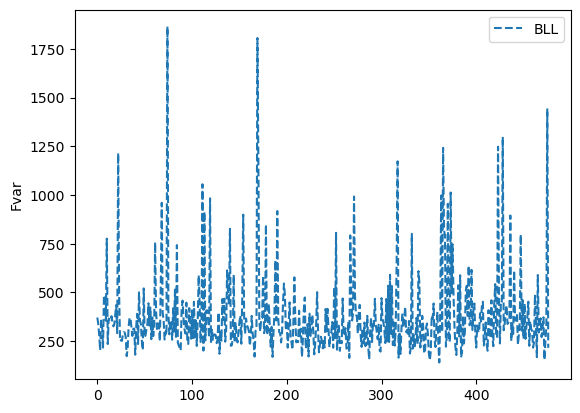

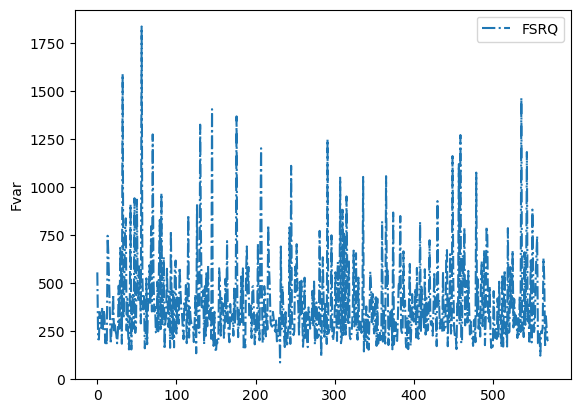

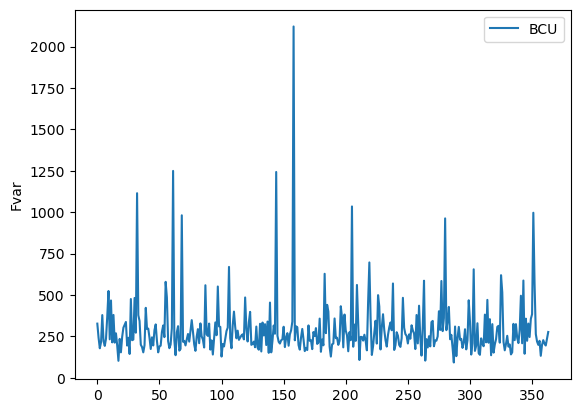

In [12]:
#Mean amp
plt.figure()
plt.plot(bll_amp,linestyle='--',label='BLL')
plt.plot(fsrq_amp,linestyle='-.',label='FSRQ')
plt.plot(bcu_amp,linestyle='-',label='BCU')
plt.ylabel('Fvar')
plt.legend(loc='best')

plt.figure()
plt.plot(bll_amp,linestyle='--',label='BLL')
plt.ylabel('Fvar')
plt.legend(loc='best')

plt.figure()
plt.plot(fsrq_amp,linestyle='-.',label='FSRQ')
plt.ylabel('Fvar')
plt.legend(loc='best')

plt.figure()
plt.plot(bcu_amp,linestyle='-',label='BCU')
plt.ylabel('Fvar')
plt.legend(loc='best')

import math

filtered_bll_amp = [x for x in bll_amp if not math.isnan(x)]
filtered_fsrq_amp = [x for x in fsrq_amp if not math.isnan(x)]
filtered_bcu_amp = [x for x in bcu_amp if not math.isnan(x)]

#Mean Fvar values
print('Mean Amp values for the different types of blazars')
print('BLLs')
print(np.mean(filtered_bll_amp))
print('FSRQs')
print(np.mean(filtered_fsrq_amp))
print('BCUs')
print(np.mean(filtered_bcu_amp))

Median number of NaN bins for the different types of blazars
BLLs
93.59958071278825
FSRQs
97.68651488616463
BCUs
134.62637362637363


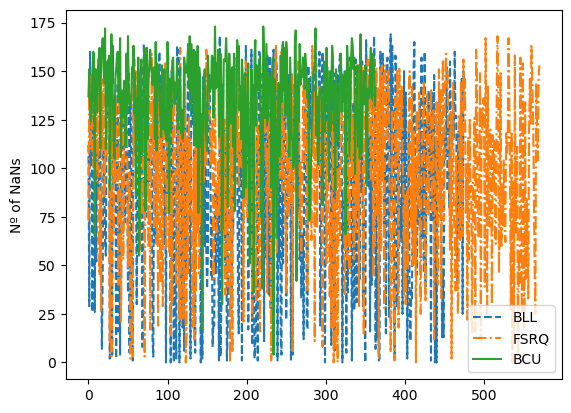

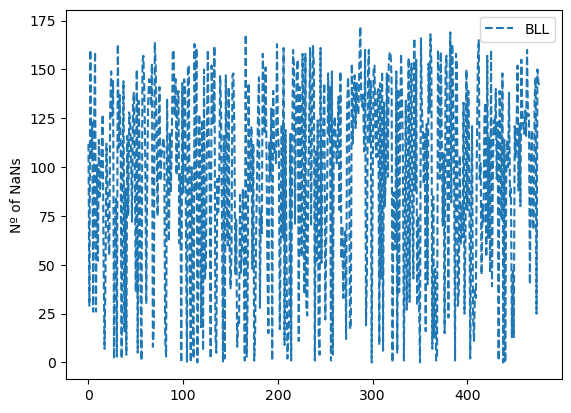

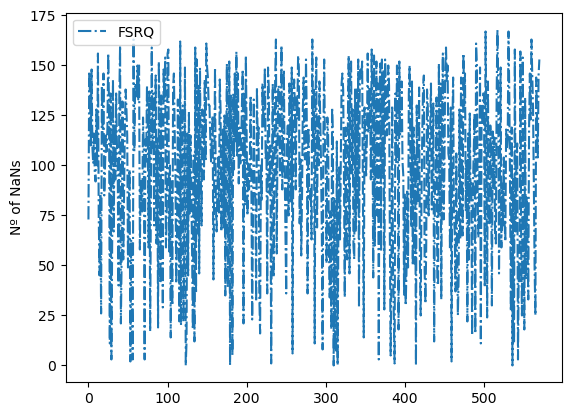

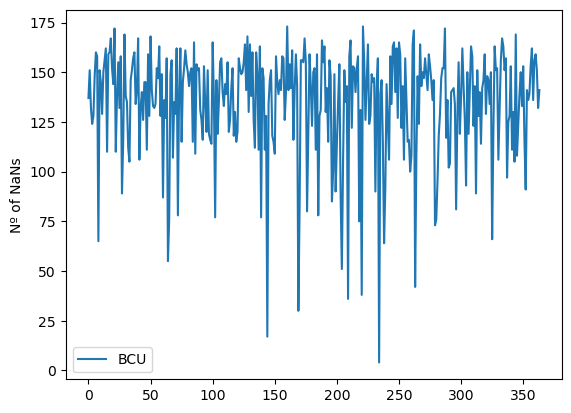

In [13]:
#NaN counting
plt.figure()
plt.plot(bll_nanbins,linestyle='--',label='BLL')
plt.plot(fsrq_nanbins,linestyle='-.',label='FSRQ')
plt.plot(bcu_nanbins,linestyle='-',label='BCU')
plt.ylabel('Nº of NaNs')
plt.legend(loc='best')

plt.figure()
plt.plot(bll_nanbins,linestyle='--',label='BLL')
plt.ylabel('Nº of NaNs')
plt.legend(loc='best')

plt.figure()
plt.plot(fsrq_nanbins,linestyle='-.',label='FSRQ')
plt.ylabel('Nº of NaNs')
plt.legend(loc='best')

plt.figure()
plt.plot(bcu_nanbins,linestyle='-',label='BCU')
plt.ylabel('Nº of NaNs')
plt.legend(loc='best')

#Mean Fvar values
print('Median number of NaN bins for the different types of blazars')
print('BLLs')
print(np.mean(bll_nanbins))
print('FSRQs')
print(np.mean(fsrq_nanbins))
print('BCUs')
print(np.mean(bcu_nanbins))

In [14]:
bll_fmatrix_plus = np.copy(bll_fmatrix)
bll_fmatrix_plus[bll_fmatrix_plus<0] = 0
#If we want this score to be representative, we need to account for the fact that not all sources
#have the same nº of non-NaN bins, so we divide by the number of points
Nbll=[]
for i in range(len(bll_fmatrix)):
    Nbll.append(np.count_nonzero(bll_fmatrix_plus[i]))
Tot_score_bll = np.nansum(bll_fmatrix_plus, axis=1)/(np.array(Nbll)-1)

fsrq_fmatrix_plus = np.copy(fsrq_fmatrix)
fsrq_fmatrix_plus[fsrq_fmatrix_plus<0] = 0
Nfsrq=[]
for i in range(len(fsrq_fmatrix)):
    Nfsrq.append(np.count_nonzero(fsrq_fmatrix_plus[i]))
Tot_score_fsrq = np.nansum(fsrq_fmatrix_plus, axis=1)/(np.array(Nfsrq)-1)

bcu_fmatrix_plus = np.copy(bcu_fmatrix)
bcu_fmatrix_plus[bcu_fmatrix_plus<0] = 0
Nbcu=[]
for i in range(len(bcu_fmatrix)):
    Nbcu.append(np.count_nonzero(bcu_fmatrix_plus[i]))
Tot_score_bcu = np.nansum(bcu_fmatrix_plus, axis=1)/(np.array(Nbcu)-1)

print(np.mean(Tot_score_bll), np.mean(Tot_score_fsrq), np.mean(Tot_score_bcu))

#Still I am not sure if this score will be representative, since it only sums factors of the ratio of individual
#fluxes over the mean flux, it depends on the average level and the amount of variability above and below the 
#average

1.0213239274965176 1.019191375839888 1.0381103218147631


3.735512054527648 3.907877468218885 2.9046538547147076


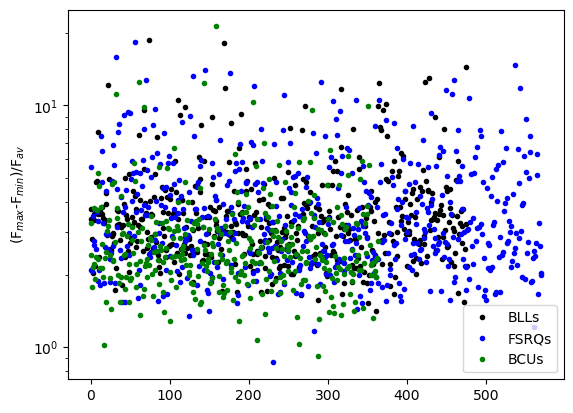

In [15]:
#I am doing tests with other metrics, for now I am measuring as a variability score the difference between maximum
#and minimum flux, divided by the average flux
bll_maxflux=np.array(bll_maxflux)
bll_minflux=np.array(bll_minflux)
fsrq_maxflux=np.array(fsrq_maxflux)
fsrq_minflux=np.array(fsrq_minflux)
bcu_maxflux=np.array(bcu_maxflux)
bcu_minflux=np.array(bcu_minflux)

Tot_score_bll2=(bll_maxflux-bll_minflux)/bll_avflux
Tot_score_fsrq2=(fsrq_maxflux-fsrq_minflux)/fsrq_avflux
Tot_score_bcu2=(bcu_maxflux-bcu_minflux)/bcu_avflux

print(np.mean(Tot_score_bll2), np.mean(Tot_score_fsrq2), np.mean(Tot_score_bcu2))

plt.figure()
plt.plot(Tot_score_bll2,'.k',label='BLLs')
plt.plot(Tot_score_fsrq2,'.b',label='FSRQs')
plt.plot(Tot_score_bcu2,'.g',label='BCUs')
plt.ylabel(r'(F$_{max}$-F$_{min}$)/F$_{av}$')
plt.yscale('log')
plt.legend(loc='best')

In [16]:
bll_fractionalfluxT = np.array(bll_fractionalflux).T
bll_var = np.sort(bll_fractionalfluxT[-2].astype(float))
bll_varerr = bll_fractionalfluxT[-1].astype(float)

fsrq_fractionalfluxT = np.array(fsrq_fractionalflux).T
fsrq_var = np.sort(fsrq_fractionalfluxT[-2].astype(float))
fsrq_varerr = fsrq_fractionalfluxT[-1].astype(float)

bcu_fractionalfluxT = np.array(bcu_fractionalflux).T
bcu_var = np.sort(bcu_fractionalfluxT[-2].astype(float))
bcu_varerr = bcu_fractionalfluxT[-1].astype(float)

Text(0.5, 0, 'Source')

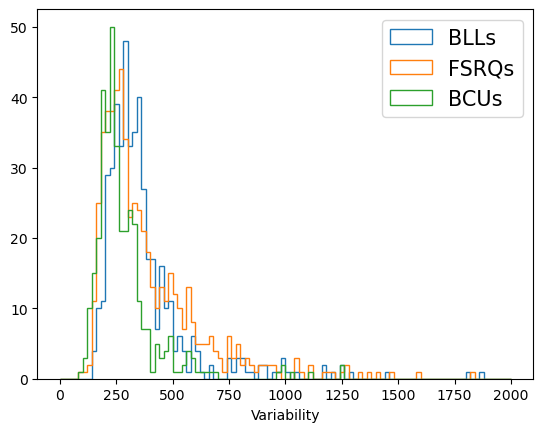

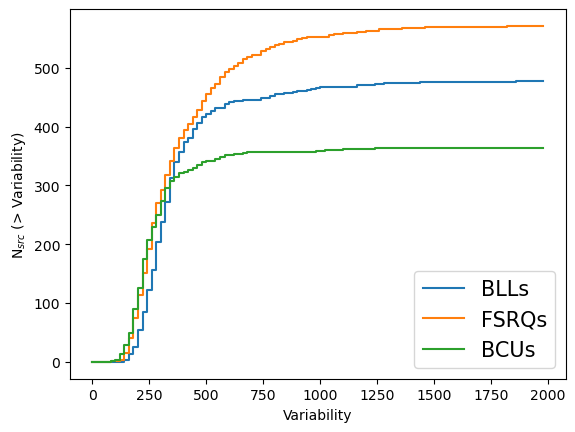

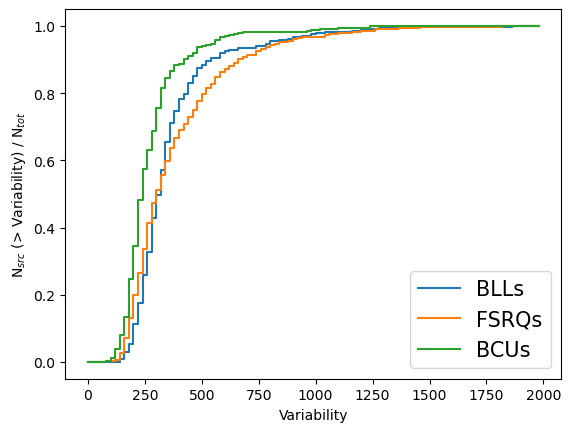

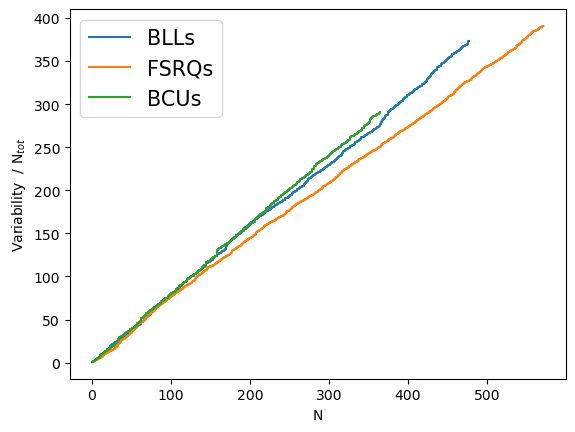

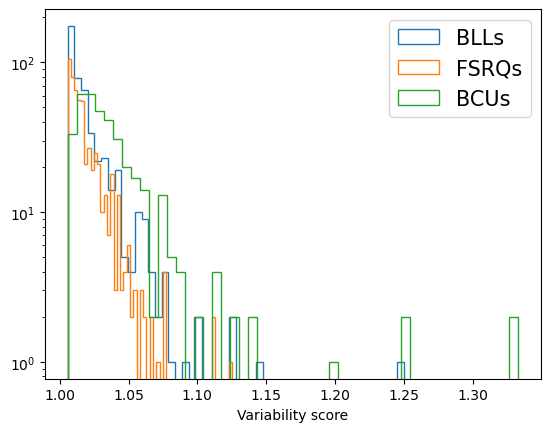

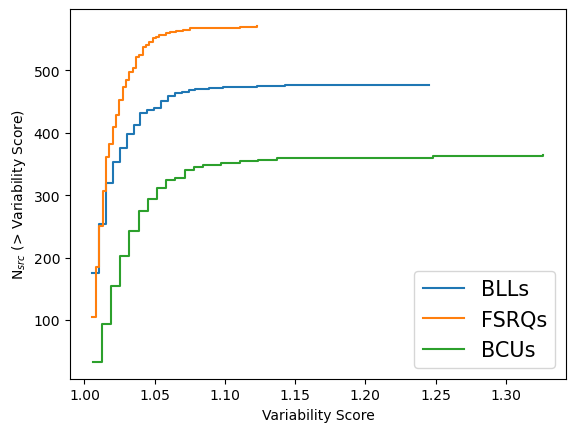

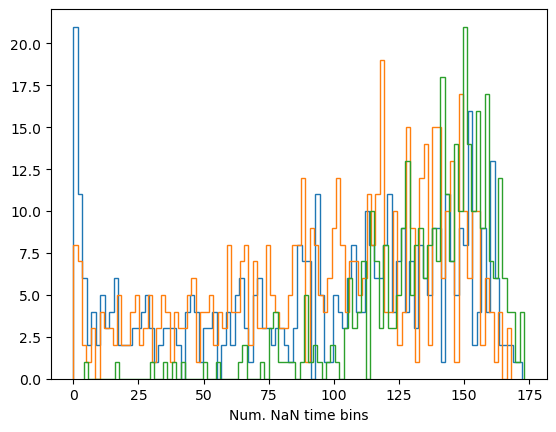

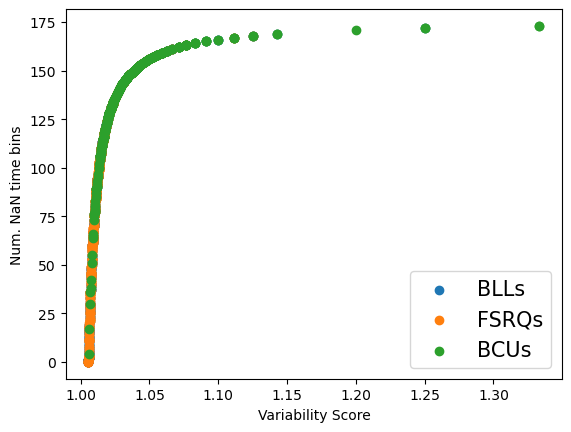

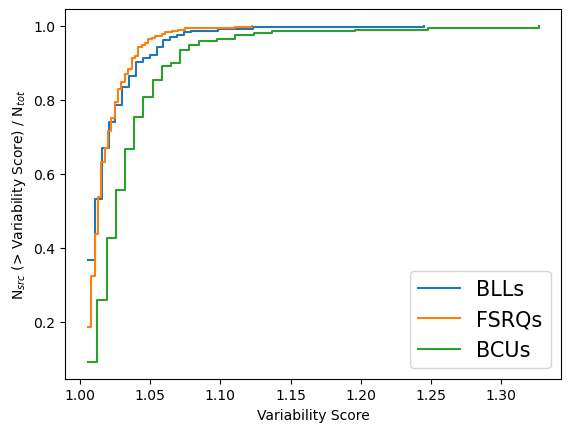

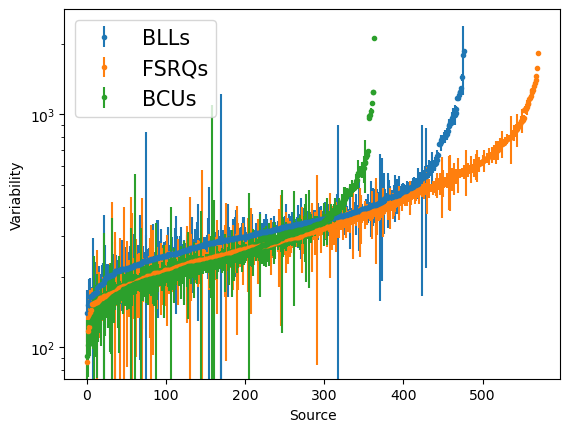

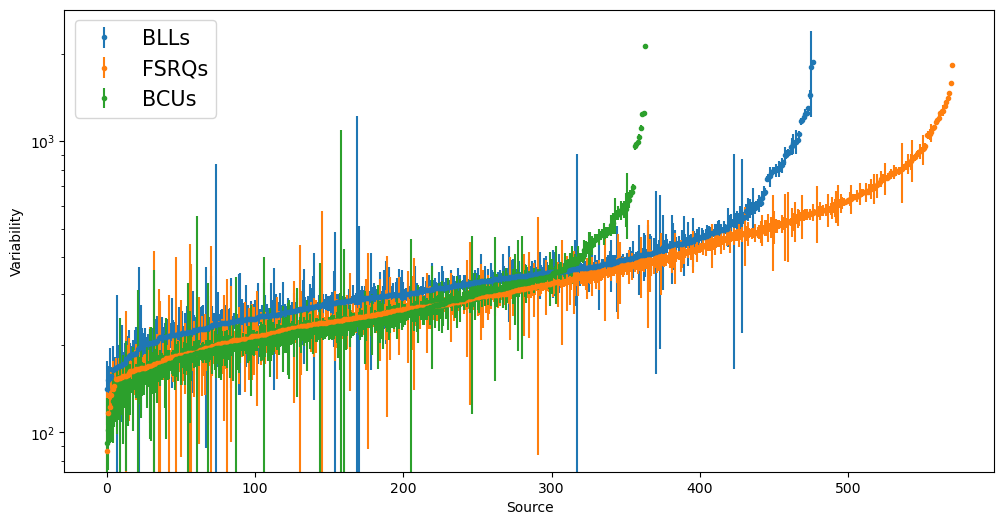

In [17]:
plt.figure()
bllh, bllhx, bllp = plt.hist(bll_amp, bins=100, range=(0, 2000),histtype='step', label='BLLs')
fsrqh, fsrqhx, fsrqp = plt.hist(fsrq_amp, bins=100,range=(0, 2000), histtype='step', label='FSRQs')
bcuh, bcuhx, bcup = plt.hist(bcu_amp, bins=100, range=(0, 2000),histtype='step', label='BCUs')
plt.legend(fontsize=15)
plt.xlabel('Variability')

plt.figure()
plt.step(bllhx[:-1], np.cumsum(bllh), where='post', label='BLLs')
plt.step(fsrqhx[:-1], np.cumsum(fsrqh), where='post', label='FSRQs')
plt.step(bcuhx[:-1], np.cumsum(bcuh), where='post', label='BCUs')
plt.legend(fontsize=15)
plt.xlabel('Variability')
plt.ylabel(r'N$_{src}$ (> Variability)')

plt.figure()
plt.step(bllhx[:-1], np.cumsum(bllh) / np.sum(bllh), where='post', label='BLLs')
plt.step(fsrqhx[:-1], np.cumsum(fsrqh) / np.sum(fsrqh), where='post', label='FSRQs')
plt.step(bcuhx[:-1], np.cumsum(bcuh) / np.sum(bcuh), where='post', label='BCUs')
plt.legend(fontsize=15)
plt.xlabel('Variability')
plt.ylabel(r'N$_{src}$ (> Variability) / N$_{tot}$')

plt.figure()
plt.step(np.arange(1,len(filtered_bll_amp)+1,1), np.cumsum(filtered_bll_amp) / len(filtered_bll_amp), where='post', label='BLLs')
plt.step(np.arange(1,len(filtered_fsrq_amp)+1,1), np.cumsum(filtered_fsrq_amp) / len(filtered_fsrq_amp), where='post', label='FSRQs')
plt.step(np.arange(1,len(filtered_bcu_amp)+1,1), np.cumsum(filtered_bcu_amp) / len(filtered_bcu_amp), where='post', label='BCUs')
plt.legend(fontsize=15)
plt.ylabel('Variability  / N$_{tot}$')
plt.xlabel(r'N')

plt.figure()
bllh2, bllhx2, bllp2 = plt.hist(Tot_score_bll, bins=50,  histtype='step', label='BLLs')
fsrqh2, fsrqhx2, fsrqp2 = plt.hist(Tot_score_fsrq, bins=50, histtype='step', label='FSRQs')
bcuh2, bcuhx2, bcup2 = plt.hist(Tot_score_bcu, bins=50,  histtype='step', label='BCUs')
plt.yscale('log')
plt.legend(fontsize=15)
plt.xlabel('Variability score')

plt.figure()
plt.step(bllhx2[:-1], np.cumsum(bllh2), where='post', label='BLLs')
plt.step(fsrqhx2[:-1], np.cumsum(fsrqh2), where='post', label='FSRQs')
plt.step(bcuhx2[:-1], np.cumsum(bcuh2), where='post', label='BCUs')
plt.legend(fontsize=15)
plt.xlabel('Variability Score')
plt.ylabel(r'N$_{src}$ (> Variability Score)')

plt.figure()
plt.hist(bll_nanbins, bins=100,  histtype='step', label='BLLs')
plt.hist(fsrq_nanbins, bins=100, histtype='step', label='FSRQs')
plt.hist(bcu_nanbins, bins=100, histtype='step', label='BCUs')
plt.xlabel('Num. NaN time bins')

plt.figure()
plt.scatter(Tot_score_bll, bll_nanbins,label='BLLs')
plt.scatter(Tot_score_fsrq, fsrq_nanbins, label='FSRQs')
plt.scatter(Tot_score_bcu, bcu_nanbins, label='BCUs')
plt.legend(fontsize=15)
plt.xlabel('Variability Score')
plt.ylabel(r'Num. NaN time bins')

plt.figure()
plt.step(bllhx2[:-1], np.cumsum(bllh2) / np.sum(bllh2), where='post', label='BLLs')
plt.step(fsrqhx2[:-1], np.cumsum(fsrqh2) / np.sum(fsrqh2), where='post', label='FSRQs')
plt.step(bcuhx2[:-1], np.cumsum(bcuh2) / np.sum(bcuh2), where='post', label='BCUs')
plt.legend(fontsize=15)
plt.xlabel('Variability Score')
plt.ylabel(r'N$_{src}$ (> Variability Score) / N$_{tot}$')


plt.figure()
plt.errorbar(np.arange(len(bll_var)), bll_var, yerr=bll_varerr, fmt='.', label='BLLs')
plt.errorbar(np.arange(len(fsrq_var)), fsrq_var, yerr=fsrq_varerr, fmt='.', label='FSRQs')
plt.errorbar(np.arange(len(bcu_var)), bcu_var, yerr=bcu_varerr, fmt='.', label='BCUs')

plt.legend(fontsize=15)
plt.yscale('log')
plt.ylabel('Variability')
plt.xlabel('Source')

plt.figure(figsize=(12, 6))
plt.errorbar(np.arange(len(bll_var)), bll_var, yerr=bll_varerr, fmt='.', label='BLLs')
plt.errorbar(np.arange(len(fsrq_var)), fsrq_var, yerr=fsrq_varerr, fmt='.', label='FSRQs')
plt.errorbar(np.arange(len(bcu_var)), bcu_var, yerr=bcu_varerr, fmt='.', label='BCUs')
plt.legend(fontsize=15)
plt.yscale('log')
plt.ylabel('Variability')
plt.xlabel('Source')
#plt.xlim(450, 600)
